In [1]:
import time
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
import math

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




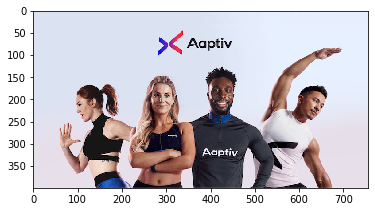

In [2]:
image_url = "images/trainers.png"
image = cv2.imread(image_url)
show_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(show_img)
plt.show()

In [3]:
# 656*368
# 432*368
w = 656
h = 368
model = "cmu"

In [ ]:
e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

In [5]:
image = common.read_imgfile(image_url, None, None)

In [6]:
t = time.time()
humans = e.inference(
    image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0
)
elapsed = time.time() - t
elapsed

2.898754835128784

In [7]:
humans[0]

BodyPart:0-(0.38, 0.50) score=0.88 BodyPart:1-(0.38, 0.67) score=0.76 BodyPart:2-(0.32, 0.68) score=0.63 BodyPart:3-(0.30, 0.84) score=0.72 BodyPart:4-(0.41, 0.80) score=0.74 BodyPart:5-(0.45, 0.66) score=0.65 BodyPart:6-(0.46, 0.85) score=0.68 BodyPart:7-(0.36, 0.87) score=0.64 BodyPart:8-(0.33, 0.97) score=0.14 BodyPart:11-(0.41, 0.98) score=0.18 BodyPart:14-(0.37, 0.47) score=0.82 BodyPart:15-(0.40, 0.48) score=0.80 BodyPart:16-(0.35, 0.50) score=0.76 BodyPart:17-(0.42, 0.50) score=0.86

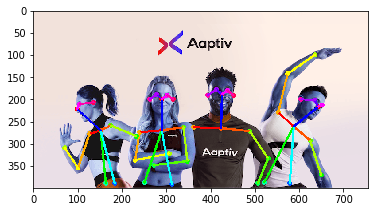

In [8]:
image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
plt.imshow(image)
plt.show()

In [55]:
0.38 * w + 0.5

249.78

In [31]:
moves = dict()
for i in humans[0].body_parts:
    part = humans[0].body_parts[i]
    moves[part.get_part_name()] = (part.x, part.y)
    print(f"x:{part.x} y:{part.y} {part.get_part_name()}")

x:0.38414634146341464 y:0.5 CocoPart.Nose
x:0.38414634146341464 y:0.6739130434782609 CocoPart.Neck
x:0.3170731707317073 y:0.6847826086956522 CocoPart.RShoulder
x:0.3048780487804878 y:0.842391304347826 CocoPart.RElbow
x:0.4054878048780488 y:0.8043478260869565 CocoPart.RWrist
x:0.4481707317073171 y:0.657608695652174 CocoPart.LShoulder
x:0.4603658536585366 y:0.8478260869565217 CocoPart.LElbow
x:0.3597560975609756 y:0.8695652173913043 CocoPart.LWrist
x:0.3323170731707317 y:0.967391304347826 CocoPart.RHip
x:0.4146341463414634 y:0.9782608695652174 CocoPart.LHip
x:0.36890243902439024 y:0.47282608695652173 CocoPart.REye
x:0.39939024390243905 y:0.4782608695652174 CocoPart.LEye
x:0.3475609756097561 y:0.5 CocoPart.REar
x:0.4176829268292683 y:0.5 CocoPart.LEar


In [13]:
humans[1].body_parts

{0: BodyPart:0-(0.56, 0.47) score=0.78,
 1: BodyPart:1-(0.56, 0.66) score=0.73,
 2: BodyPart:2-(0.48, 0.66) score=0.71,
 5: BodyPart:5-(0.65, 0.68) score=0.70,
 6: BodyPart:6-(0.70, 0.83) score=0.72,
 7: BodyPart:7-(0.67, 0.97) score=0.28,
 14: BodyPart:14-(0.55, 0.45) score=0.81,
 15: BodyPart:15-(0.58, 0.45) score=0.90,
 16: BodyPart:16-(0.52, 0.48) score=0.77,
 17: BodyPart:17-(0.60, 0.48) score=0.74}

In [14]:
head = [(common.CocoPart.Neck, common.CocoPart.Nose)]
left_upper_body = [
    (common.CocoPart.LShoulder, common.CocoPart.LElbow),
    (common.CocoPart.LElbow, common.CocoPart.LWrist),
]
right_upper_body = [
    (common.CocoPart.LShoulder, common.CocoPart.LElbow),
    (common.CocoPart.LElbow, common.CocoPart.LWrist),
]
left_lower_body = [
    (common.CocoPart.LHip, common.CocoPart.LKnee),
    (common.CocoPart.LKnee, common.CocoPart.LAnkle),
]
right_lower_body = [
    (common.CocoPart.RHip, common.CocoPart.RKnee),
    (common.CocoPart.RKnee, common.CocoPart.RAnkle),
]
stress_points = head + left_upper_body + left_lower_body + right_upper_body + right_lower_body

In [15]:
def generate_positions(start_cor, end_cor, start_std=0.01, end_std=0.2, sample_size=1):
    start_x, start_y = start_cor
    end_x, end_y = end_cor

    start_x_list = np.random.normal(start_x, start_std, sample_size)
    start_y_list = np.random.normal(start_y, start_std, sample_size)

    end_x_list = np.random.normal(start_x, end_std, sample_size)
    end_y_list = np.random.normal(start_x, end_std, sample_size)

    return (
        np.array(list(zip(start_x_list, start_y_list))),
        np.array(list(zip(end_x_list, end_y_list))),
    )

In [16]:
start_cor_list, end_cor_list = generate_positions(
    (0.421, 0.22), (0.365, 0.282), start_std=0.2, end_std=0.5, sample_size=10
)
start_cor_list, end_cor_list

(array([[ 0.74719579,  0.03278657],
        [ 0.51350219,  0.25428613],
        [ 0.3095599 , -0.01535352],
        [ 0.42167877,  0.39690318],
        [ 0.60896118,  0.23425528],
        [ 0.44354089,  0.10715871],
        [ 0.86524978, -0.161783  ],
        [ 0.4020295 ,  0.39131235],
        [ 0.3251264 ,  0.18781545],
        [ 0.51899249,  0.38971139]]), array([[ 0.80561783,  0.19545078],
        [ 0.01184071,  0.03000904],
        [ 1.18048733,  0.72862302],
        [ 1.51783   ,  0.39076839],
        [ 0.30895344,  0.72255753],
        [ 0.29866133, -0.17984441],
        [ 0.13512225,  0.5500435 ],
        [ 1.04608388,  0.70919818],
        [ 0.25501261,  0.66447935],
        [ 0.6395123 ,  0.10536096]]))

In [17]:
np.array(
    list(
        zip(
            list(zip(start_cor_list[:, 0], end_cor_list[:, 0])),
            list(zip(start_cor_list[:, 1], end_cor_list[:, 1])),
        )
    )
).reshape(20,2)

array([[ 0.74719579,  0.80561783],
       [ 0.03278657,  0.19545078],
       [ 0.51350219,  0.01184071],
       [ 0.25428613,  0.03000904],
       [ 0.3095599 ,  1.18048733],
       [-0.01535352,  0.72862302],
       [ 0.42167877,  1.51783   ],
       [ 0.39690318,  0.39076839],
       [ 0.60896118,  0.30895344],
       [ 0.23425528,  0.72255753],
       [ 0.44354089,  0.29866133],
       [ 0.10715871, -0.17984441],
       [ 0.86524978,  0.13512225],
       [-0.161783  ,  0.5500435 ],
       [ 0.4020295 ,  1.04608388],
       [ 0.39131235,  0.70919818],
       [ 0.3251264 ,  0.25501261],
       [ 0.18781545,  0.66447935],
       [ 0.51899249,  0.6395123 ],
       [ 0.38971139,  0.10536096]])

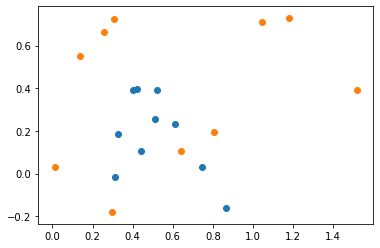

In [18]:
plt.scatter(x=start_cor_list[:, 0], y=start_cor_list[:, 1])
plt.scatter(x=end_cor_list[:, 0], y=end_cor_list[:, 1])

In [46]:
def show_tracks(start_cor_list, end_cor_list):
    plt.scatter(x=start_cor_list[:, 0], y=start_cor_list[:, 1])
    plt.scatter(x=end_cor_list[:, 0], y=end_cor_list[:, 1])
    ax = plt.gca()
    args = np.array(
        list(
            zip(
                list(zip(start_cor_list[:, 0], end_cor_list[:, 0])),
                list(zip(start_cor_list[:, 1], end_cor_list[:, 1])),
            )
        )
    ).reshape(len(start_cor_list) * 2, 2)
    ax.plot(*args, marker="o")

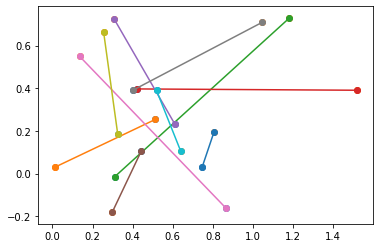

In [44]:
show_tracks(start_cor_list, end_cor_list)

In [20]:
orginal_start_point = start_cor_list[0]
shifted_start_cor_list = start_cor_list.copy()
shifted_end_cor_list = end_cor_list.copy()

shifted_end_cor_list[:, 0] = shifted_end_cor_list[:, 0] - (
    shifted_start_cor_list[:, 0] - orginal_start_point[0]
)
shifted_end_cor_list[:, 1] = shifted_end_cor_list[:, 1] - (
    shifted_start_cor_list[:, 1] - orginal_start_point[1]
)
shifted_start_cor_list[:] = orginal_start_point

In [21]:
shifted_start_cor_list, shifted_end_cor_list

(array([[0.74719579, 0.03278657],
        [0.74719579, 0.03278657],
        [0.74719579, 0.03278657],
        [0.74719579, 0.03278657],
        [0.74719579, 0.03278657],
        [0.74719579, 0.03278657],
        [0.74719579, 0.03278657],
        [0.74719579, 0.03278657],
        [0.74719579, 0.03278657],
        [0.74719579, 0.03278657]]), array([[ 0.80561783,  0.19545078],
        [ 0.24553431, -0.19149051],
        [ 1.61812322,  0.77676311],
        [ 1.84334703,  0.02665178],
        [ 0.44718805,  0.52108882],
        [ 0.60231623, -0.25421655],
        [ 0.01706826,  0.74461308],
        [ 1.39125017,  0.35067241],
        [ 0.677082  ,  0.50945047],
        [ 0.8677156 , -0.25156386]]))

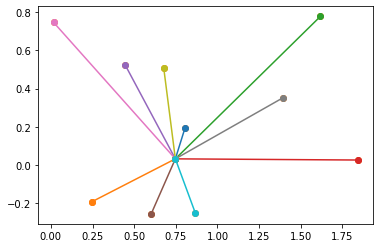

In [48]:
show_tracks(shifted_start_cor_list, shifted_end_cor_list)

In [24]:
arr_corr = np.array(list(zip(start_cor_list[:], end_cor_list[:])))
arr_corr = arr_corr.reshape((arr_corr.shape[0] * arr_corr.shape[1], arr_corr.shape[2]))
arr_corr.tolist()

[[0.7471957906391478, 0.032786573809155284],
 [0.8056178309282587, 0.19545077895947674],
 [0.5135021891788025, 0.2542861302859713],
 [0.011840710110770314, 0.030009044422365516],
 [0.30955990146771245, -0.015353523735177704],
 [1.180487327271682, 0.7286230171589583],
 [0.42167876709536967, 0.39690318203726127],
 [1.517830004419015, 0.39076838538175374],
 [0.6089611830461792, 0.23425528351526742],
 [0.30895344079835924, 0.7225575272348312],
 [0.4435408929368544, 0.10715870858394964],
 [0.2986613315070128, -0.17984441231652742],
 [0.865249784350381, -0.16178300457138975],
 [0.13512225367118902, 0.5500435045935346],
 [0.4020294997282683, 0.3913123484461447],
 [1.0460838763534812, 0.7091981849998743],
 [0.3251264030603528, 0.18781544949492054],
 [0.255012611412271, 0.664479345157774],
 [0.5189924902793756, 0.3897113939902511],
 [0.6395123044292857, 0.10536095866392287]]

In [27]:
from sklearn.metrics.pairwise import (
    cosine_similarity,
    euclidean_distances,
    haversine_distances,
)


def get_travel_angles(start_cor_list, end_cor_list):
    travels = 0
    cosine = -1
    for start, end in zip(start_cor_list, end_cor_list):
        if cosine < 0:
            cosine = cosine_similarity(np.array([start, end]))[0, 1]
            print(cosine)
            continue
        new_cosine = cosine_similarity(np.array([start, end]))[0, 1]
        print(new_cosine)
        travels += np.abs(new_cosine - cosine)
        cosine = new_cosine
    return travels


def get_haversine_distances(start_cor_list, end_cor_list):
    travels = 0
    cosine = -1
    for idx, end in enumerate(end_cor_list[:-2]):
        hs_distances = haversine_distances(np.array([end, end_cor_list[idx + 1]]))[0, 1]
        print(hs_distances)
        travels += hs_distances
    return travels


def get_euclidean_distances(start_cor_list, end_cor_list):
    travels = 0
    cosine = -1
    for idx, end in enumerate(end_cor_list[:-2]):
        ed_distance = euclidean_distances(np.array([end, end_cor_list[idx + 1]]))
        print(ed_distance)
        travels += ed_distance[0, 1]
    return travels


def get_part_length(start_cor_list, end_cor_list):
    lengths = []
    for start, end in zip(start_cor_list, end_cor_list):
        distance = euclidean_distances(np.array([start, end]))[0, 1]
        lengths.append(distance)
    return np.mean(lengths)

In [28]:
get_haversine_distances(start_cor_list, end_cor_list)

0.8069559375474205
1.26372142012909
0.3407664140867008
1.2118161319529992
0.8583117819069437
0.729656839573089
0.9188778117477693
0.7917525472270917


6.921858884171104

In [29]:
get_haversine_distances(shifted_start_cor_list, shifted_end_cor_list)

0.647596209273242
1.3522665134892755
0.24004949344312954
1.3665594404984371
0.6830539045129128
1.0977066676953804
1.3881085322897553
0.7168371139557821


7.492177875157914

In [128]:
get_travel_angles(shifted_start_cor_list, shifted_end_cor_list)

0.9457451917427775
0.9297898036688771
0.9995574601020228
0.9206830182925209
0.9993392064480608
0.9285820675963986
0.983145553820055
0.7009729055459101
0.9967654037927016
0.8448201786826522


1.0984846711783924

In [ ]:
get_travel_angles(shifted_start_cor_list, shifted_end_cor_list)

In [30]:
def get_burned_eneries(start_cor_list, end_cor_list, enery_factor = 5):
    distance = get_haversine_distances(start_cor_list, end_cor_list)
    return distance * enery_factor

In [ ]:
x:0.38414634146341464 y:0.5 CocoPart.Nose
x:0.38414634146341464 y:0.6739130434782609 CocoPart.Neck
x:0.3170731707317073 y:0.6847826086956522 CocoPart.RShoulder
x:0.3048780487804878 y:0.842391304347826 CocoPart.RElbow
x:0.4054878048780488 y:0.8043478260869565 CocoPart.RWrist
x:0.4481707317073171 y:0.657608695652174 CocoPart.LShoulder
x:0.4603658536585366 y:0.8478260869565217 CocoPart.LElbow
x:0.3597560975609756 y:0.8695652173913043 CocoPart.LWrist
x:0.3323170731707317 y:0.967391304347826 CocoPart.RHip
x:0.4146341463414634 y:0.9782608695652174 CocoPart.LHip
x:0.36890243902439024 y:0.47282608695652173 CocoPart.REye
x:0.39939024390243905 y:0.4782608695652174 CocoPart.LEye
x:0.3475609756097561 y:0.5 CocoPart.REar
x:0.4176829268292683 y:0.5 CocoPart.LEar

In [42]:
head_move_points = []

for start, end in head:
    print(start, end)
    start, end = moves[start], moves[end]
    start_list, end_list = generate_positions(
        start, end, start_std=0.01, end_std=0.2, sample_size=10
    )
    head_move_points.append([start_list, end_list])

CocoPart.Neck CocoPart.Nose


In [52]:
# args = 
show_tracks([(0.3841, 0.673)],[(0.3, 0.5)])

TypeError: list indices must be integers or slices, not tuple

In [53]:
head_move_points

[[array([[0.38043291, 0.65934985],
         [0.36729121, 0.68345963],
         [0.37442162, 0.66546878],
         [0.38356441, 0.66746788],
         [0.37742369, 0.68160285],
         [0.40473913, 0.68151652],
         [0.3929471 , 0.68173901],
         [0.39092938, 0.6638357 ],
         [0.37354302, 0.67321933],
         [0.37356869, 0.64393506]]), array([[0.33258404, 0.31832146],
         [0.39026932, 0.54936273],
         [0.37730244, 0.26189198],
         [0.26786373, 0.23338426],
         [0.46411604, 0.60163424],
         [0.36682134, 0.41971371],
         [0.39301263, 0.57711416],
         [0.49877936, 0.31287051],
         [0.41443261, 0.259238  ],
         [0.46118427, 0.12268044]])]]

In [ ]:
head = [(common.CocoPart.Neck, common.CocoPart.Nose)]
left_upper_body = [
    (common.CocoPart.LShoulder, common.CocoPart.LElbow),
    (common.CocoPart.LElbow, common.CocoPart.LWrist),
]
right_upper_body = [
    (common.CocoPart.LShoulder, common.CocoPart.LElbow),
    (common.CocoPart.LElbow, common.CocoPart.LWrist),
]
left_lower_body = [
    (common.CocoPart.LHip, common.CocoPart.LKnee),
    (common.CocoPart.LKnee, common.CocoPart.LAnkle),
]
right_lower_body = [
    (common.CocoPart.RHip, common.CocoPart.RKnee),
    (common.CocoPart.RKnee, common.CocoPart.RAnkle),
]
stress_points = head + left_upper_body + left_lower_body + right_upper_body + right_lower_body

In [ ]:
x:0.4212962962962963-y:0.22282608695652173 CocoPart.RShoulder
x:0.36574074074074076-y:0.2826086956521739 CocoPart.RElbow
x:0.27314814814814814-y:0.32065217391304346 CocoPart.RWrist